# Vehicle Detection and Tracking Project

### Author: Marko Sarkanj

## The goals / steps of this project are the following

- Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
- Apply a color transform and append binned color features, as well as histograms of color, to HOG feature vector.
- Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
- Run  pipeline on a video stream.
- Create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
- Estimate a bounding box for vehicles detected.

### For the project I have used following resurces as main sources of infromation:
- Udacity lectures
- Ryan Keenan's questions and answers youtube session
- Udacity's Slack channel

## Step 0: Import all necessary Python packages

In [94]:
import numpy as np
import os
import cv2
import time
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from moviepy.editor import VideoFileClip
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## Step 1: Histogram of Oriented Gradients (HOG) Extraction

First step that I did is importing cars and non-cars sample images. Sample images have been imported with help of glob function.

In [118]:
# Load all vehicles samples.

basedir = 'vehicles/'
image_types = os.listdir(basedir)

images = glob.glob('*.jpeg')
cars = []
for imtype in image_types:
    cars.extend(glob.glob(basedir+imtype+'/*'))

print('Number of detected vehicles:', len(cars))

with open("cars.txt", 'w') as f:
    for fn in cars:
        f.write(fn+'\n')

# Load all non-vehicles samples

basedir = 'non-vehicles/'
image_types = os.listdir(basedir)

images = glob.glob('*.jpeg')
non_cars = []
for imtype in image_types:
    non_cars.extend(glob.glob(basedir+imtype+'/*'))

print('Number of detected non-vehicles:', len(non_cars))

with open("notcars.txt", 'w') as f:
    for fn in non_cars:
        f.write(fn+'\n')

Number of detected vehicles: 8792
Number of detected non-vehicles: 8968


Next I have defined 3 functions. 

First function get_hog_features will export histogram oriented gradients from the image.

Second function bin_spatial is computing binned color futures on image resized to 32x32 by default.

Third function color_hist computes color histograms as the last parameter based upon which I will later train SVM classifier.

In [343]:
# The function bellow extracts HOG features from the image based on orient, pixels per cell and cell per block 
# parameters. Optionally it is possible to return image showing HOG gradients as well.

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
# The function bellow resizes the image and flattens the color matrix for each color channel.

def bin_spatial(img, size=(32, 32)):

    color1 = cv2.resize(img[:,:,0], size).ravel() 
    color2 = cv2.resize(img[:,:,1], size).ravel() 
    color3 = cv2.resize(img[:,:,2], size).ravel() 
    # Color channels are combined into one future vector returned from the funciton.
    return np.hstack((color1, color2, color3))

# The function bellow computes histogram
# for each of three color channels and returns concatenated histogram features for all three channels.

def color_hist(img, nbins=32):
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

Now that I have defined basic feature extraction functions I can extract all the features described above from a single image. Extracted features will represent an input for future classifier training.

In [ ]:
# convert_color is just a helper function that serves to make code more readable.  
# This funciton transforms image to a given color channel.

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    
# singe_img_features function contains numerous parameters to be able to cover all variations in color channel, 
# HOG parameters, spatial size and which of the features will be used to form a feature vector.
   
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):
    
    # First I have created one empty array that will contain features.
    img_features = []
    
    # Different color conversion are necessary based on color_space input. In this project I have decided
    # for YCrCb.
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)   
    else: feature_image = np.copy(img) # In case of RGB the imput image will be simply copied.  
    if spatial_feat == True:
        # Spatial color features will be extracted with the help of bin_spatial function described previously.
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
    if hist_feat == True:
        # Color histogram features will be extracted with the help of color_hist function described previously.
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)
    if hog_feat == True:
        if hog_channel  == 'ALL': # In case that we want to perform HOG extraction based on all 3 color channels
                                  # HOG gradients will be extracted separately and then concatenated.
            hog_features = [] 
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel],
                                                    orient, pix_per_cell, cell_per_block,
                                                    vis=False, feature_vec=True))
            hog_features = np.concatenate(hog_features)
        else: # In case that only one channel has been selected for the color extraction there are two options:
            if vis == True: # HOG features and image with HOG gradients can be returned.
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel],
                                            orient, pix_per_cell, cell_per_block,
                                            vis=True, feature_vec=True)
            else: # Or only HOG features can be returned.
                hog_features = get_hog_features(feature_image[:,:,hog_channel],
                                                orient, pix_per_cell, cell_per_block,
                                                vis=False, feature_vec=True)
        
        img_features.append(hog_features) # HOG features are appended feature vector.
    
    if vis == True:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)

extract_features function is basically the same as single_img_features funciton and this is why it will not be described with comments in code separately. The reason why I have defined extract_features function is to demo how color HOG gradients are calculated based on different input images.

In [121]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    features = []
    for file in imgs:
        file_features = []
        image = mpimg.imread(file)
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            if hog_channel  == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel],
                                                        orient, pix_per_cell, cell_per_block,
                                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel],
                                               orient, pix_per_cell, cell_per_block,
                                               vis=False, feature_vec=True)
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    return features

Bellow I have used previously described functions  to demonstrate how the HOG gradient is calculated. Used parameters are described in code.

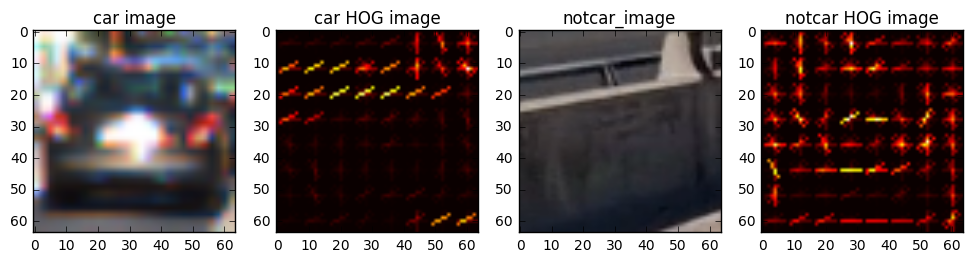

In [342]:
%matplotlib inline

# First random cars and non-car images were chosen.
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(non_cars))

car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(non_cars[notcar_ind])

# The following parameters were defined to be used in previously described single_img_features:

color_space = 'RGB' # In this case I will exceptionally use RGB color space so that the images stay unchanged.
orient = 6 # Number HOG gradient orientations.
pix_per_cell = 8 # Number of pixels that will be used in one cell .
cell_per_block = 2 # Number of cells per block.
hog_channel = 0 # HOG channel used (in this case only one, 0)
spatial_size = (16,16) # Dimensions to which images will be resized in bin_spatial function.
hist_bis = 16 # Number of bins used in hist_feat function
spatial_feat = True # All three possible features are true as we will generate all three of them.
hist_feat = True
hog_feat = True

car_features, notcar_hog_image = single_img_features(car_image, color_space=color_space, spatial_size=sptial_size,
                        hist_bins=hist_bis, orient=orient,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis=True)

notcar_features, car_hog_image = single_img_features(notcar_image, color_space=color_space, spatial_size=sptial_size,
                        hist_bins=hist_bis, orient=orient,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis=True)

images = [car_image, car_hog_image, notcar_image, notcar_hog_image]
titles = ['car image', 'car HOG image', 'notcar_image','notcar HOG image']
fig = plt.figure(figsize=(12,3))
visualize(fig,1,4,images,titles)

Bellow I have trained the SVM classifier that will be used for cars recognition. The classifier has been trained based on cars and non-cars images imported at the beginning of the project. I have used color space YCrCb in rest of the project. After some experimentation this classifier has shown to give best test accuracy.

In [109]:
color_space = 'YCrCb'
orient = 9 # I have changed the number of HOG gradient orientations to 9 for SVM training as this number
           # of gradients shows better results
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # All color channels will be used for HOG gradients calculation in this case.
spatial_size = (32,32)
hist_bins = 32
spatial_feat = True
hist_feat = True
hog_feat = True

t = time.time()

test_cars = cars
test_noncars = non_cars

# "vis" parameter will default to False in this case, 
# because no image of HOG gradients needs to be returned for the SVM training.
car_features = extract_features(test_cars, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(test_noncars, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

# By subtracting current time with time at start of the features computation it is possible to see how much time
# was needed:
print(time.time()-t, 'Seconds to compute features ...')

# We are stacking features from both sources (cars and non-car images) together as an input for SVM classifier:
X = np.vstack((car_features, notcar_features)).astype(np.float64) 

# All of the features have been scaled before training the classifier:
X_scaler = StandardScaler().fit(X)

scaled_X = X_scaler.transform(X)

# Ones will represent cars and zeroes non-cars in y array:
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# I have splitted the samples to 90% for taining and 10% for validation. It is very 
# important to mix the samples as well (to avoid overfitting): 
rand_state = np.random.randint(0,100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.1,
                                                   random_state=rand_state)

print('Using:',orient,'orientations,',pix_per_cell,'pixels per cell',cell_per_block,
     'cells per block,',hist_bins,'histogram bins, and',spatial_size,'spatial sampling')
print('Feature wector length:',len(X_train[0]))

# SVM classifier has been trained with the accuracy calculated after the classifier training:
svc = LinearSVC()
t=time.time()
svc.fit(X_train, y_train)
print(round(time.time()-t,2),'Seconds to train SVC...')

print('Test Accuracy of SVC = ',round(svc.score(X_test,y_test), 4))

81.19689297676086 Seconds to compute features ...
Using: 9 orientations, 8 pixels per cell 2 cells per block, 32 histogram bins, and (32, 32) spatial sampling
Feature wector length: 8460
10.19 Seconds to train SVC...
Test Accuracy of SVC =  0.9904


## Step 2: Sliding window search.

In the function slide_window I have computed the window frame list that will be used for cars recognition. 

Each window frame will be predicted with previously trained SVC classifier and if it will be recognised as a car window that its coordinates will be saved.


In [ ]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # In case that x or y start/stop positions are not defined their size will be set to zero:
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    # Then a span of a searched region on image will be computed (to avoid clouds and trees etc.):
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Number of pixels per step need to be computed based on overlap.
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # After the number of pixels per step are computed it is possible to compute number of windows 
    # for x and y positions:
    nx_windows = np.int(xspan/nx_pix_per_step) - 1 
    ny_windows = np.int(yspan/ny_pix_per_step) - 1 
    
    window_list = [] # Empty initial window list.

    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Window starting and ending positions:
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Add a position to window list:
            window_list.append(((startx, starty), (endx, endy)))

    return window_list

As I have defined the list of window coordinates that will be searched on an image the actual search (SVM classifier prediction) needs to be performed.

I have used the search_windows function to return windows that were detected as cars by SVM classifier.

I have decided on what scales to search and how much to overlap windows based on experimentation with different parameters. Additional explanation is contained in code as comments.

In [ ]:
# Input of the function were previously explained, as they are actually inputs of previously
# defined functions.
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    on_windows = [] # I have created empty windows array first.
    for window in windows: # The window iteration and extraction can be preformed now
                           # (based on slide_window function coordinates).
        # First I have extracted the window from original image:
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        # Then the features are extracted by using the single_img_features function
        # (the same function with which the SVM classifier has been trained).
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        # The features are scaled first and then predicted by classifier:
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        prediction = clf.predict(test_features)
        # If the car has been predicted by classifier then the window coordinates will be saved in on_windows array.
        if prediction == 1:
            on_windows.append(window)

    return on_windows

The function named "visualize" is used to show window frames detected as cars drawn on sample images.

In [ ]:
def visualize(fig,rows,cols,imgs,titles): 
    for i, img in enumerate(imgs):
        plt.subplot(rows,cols,i+1)
        plt.title(i+1)
        img_dims=len(img.shape)
        if img_dims<3:
            plt.imshow(img,cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

Function draw_boxes is used to draw rectangles on an image after the car detection has been performed.

In [ ]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    draw_img = np.copy(img) # Original input image copy.
    # By iterating through bboxes array rectangles will be drawn on the image:
    for bbox in bboxes:
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    return draw_img

First I have used basic version of vehicle detection algorithm. All features have been calculated for each window separately and there were many false positives detected.  

0.0 1.0
0.37877798080444336 seconds to process one image searching 100 windows
0.0 1.0
0.3749721050262451 seconds to process one image searching 100 windows
0.0 1.0
0.37517499923706055 seconds to process one image searching 100 windows
0.0 1.0
0.38356900215148926 seconds to process one image searching 100 windows
0.0 1.0
0.3682899475097656 seconds to process one image searching 100 windows
0.0 1.0
0.37203097343444824 seconds to process one image searching 100 windows


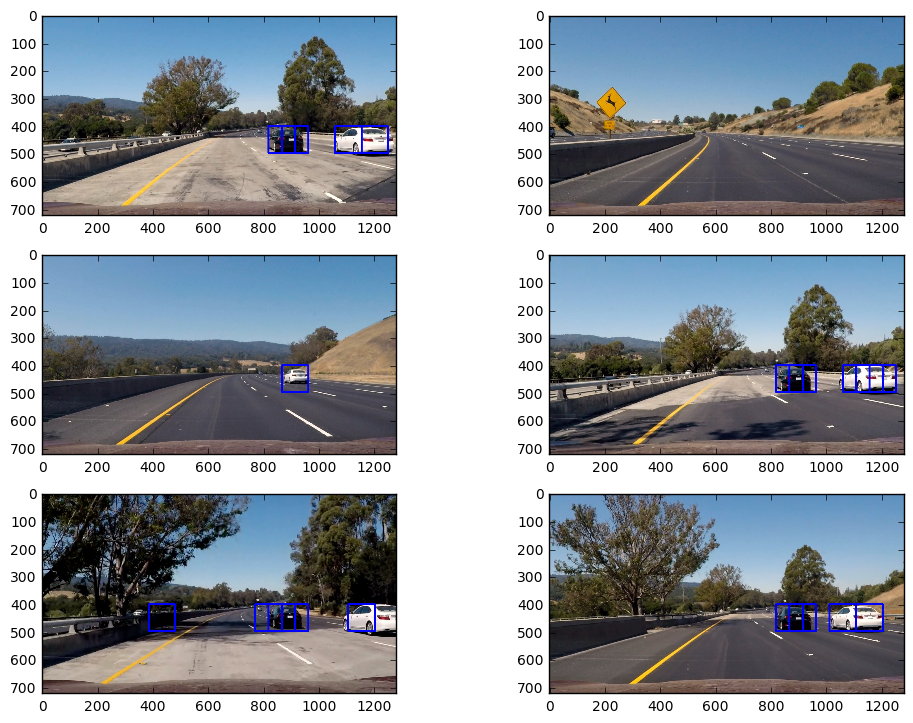

In [189]:
color_space = 'YCrCb' # All the parameters bellow have already been explained in previous functions.
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_size = (32,32)
hist_bins = 32
spatial_feat = True
hist_feat = True
hog_feat = True

searchpath = 'test_images/*' 
example_images = glob.glob(searchpath) # First I have loaded the sample images  into example_images array.
images = []
titles = []
y_start_stop = [400, 656] # Image area that will be searched for cars on image (To avoid detected cars on threes etc.).
overlap = 0.5 # Overlap that will happen when sliding a window frame through an image.

for img_src in example_images: # For each image in example_images array window frames predicted as cars will be 
                               # detected and visualised as blue rectangles on the image.
    t1 = time.time()
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    print(np.min(img), np.max(img))
    
    # Both functions bellow have previosuly been explained. Interesting parameters are xy_window=(96,96),
    # that determines the sliding windows size and x_start_stop=[None,None] that determines that cars 
    # will be searched on the whole x axis.
    
    windows = slide_window(img, x_start_stop=[None,None], y_start_stop=y_start_stop,
                           xy_window=(96,96), xy_overlap=(overlap,overlap))
    
    hot_windows = search_windows(img, windows, svc, X_scaler,color_space=color_space,
                                spatial_size=spatial_size, hist_bins = hist_bins,
                                orient=orient, pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block, hog_channel=hog_channel,
                                spatial_feat=spatial_feat, hist_feat = hist_feat, hog_feat=hog_feat)
    # When the car detection is complete now the image with the drawn rectangles (windows predicted as cars)
    # needs to be added to images array and plotted afterwards:
    window_img = draw_boxes(draw_img, hot_windows, color=(0,0,255),thick=6)
    images.append(window_img)
    titles.append('')
    print(time.time()-t1,'seconds to process one image searching', len(windows),'windows')
fig = plt.figure(figsize=(12,18))
visualize(fig, 6, 2, images, titles)

As it can be seen on the examples above there were some false positives and the car detection algorithm is not very performant.

In the improved car detection algorithm bellow HOG features were calculated only once per image to improve the performance. Heat maps were used as well to register only multiple positive window frame detections in specific image area as actual cars.

0.3449709415435791 seconds to run, total windows =  294
0.3452279567718506 seconds to run, total windows =  294
0.3186759948730469 seconds to run, total windows =  294
0.31401610374450684 seconds to run, total windows =  294
0.31517791748046875 seconds to run, total windows =  294
0.3264639377593994 seconds to run, total windows =  294


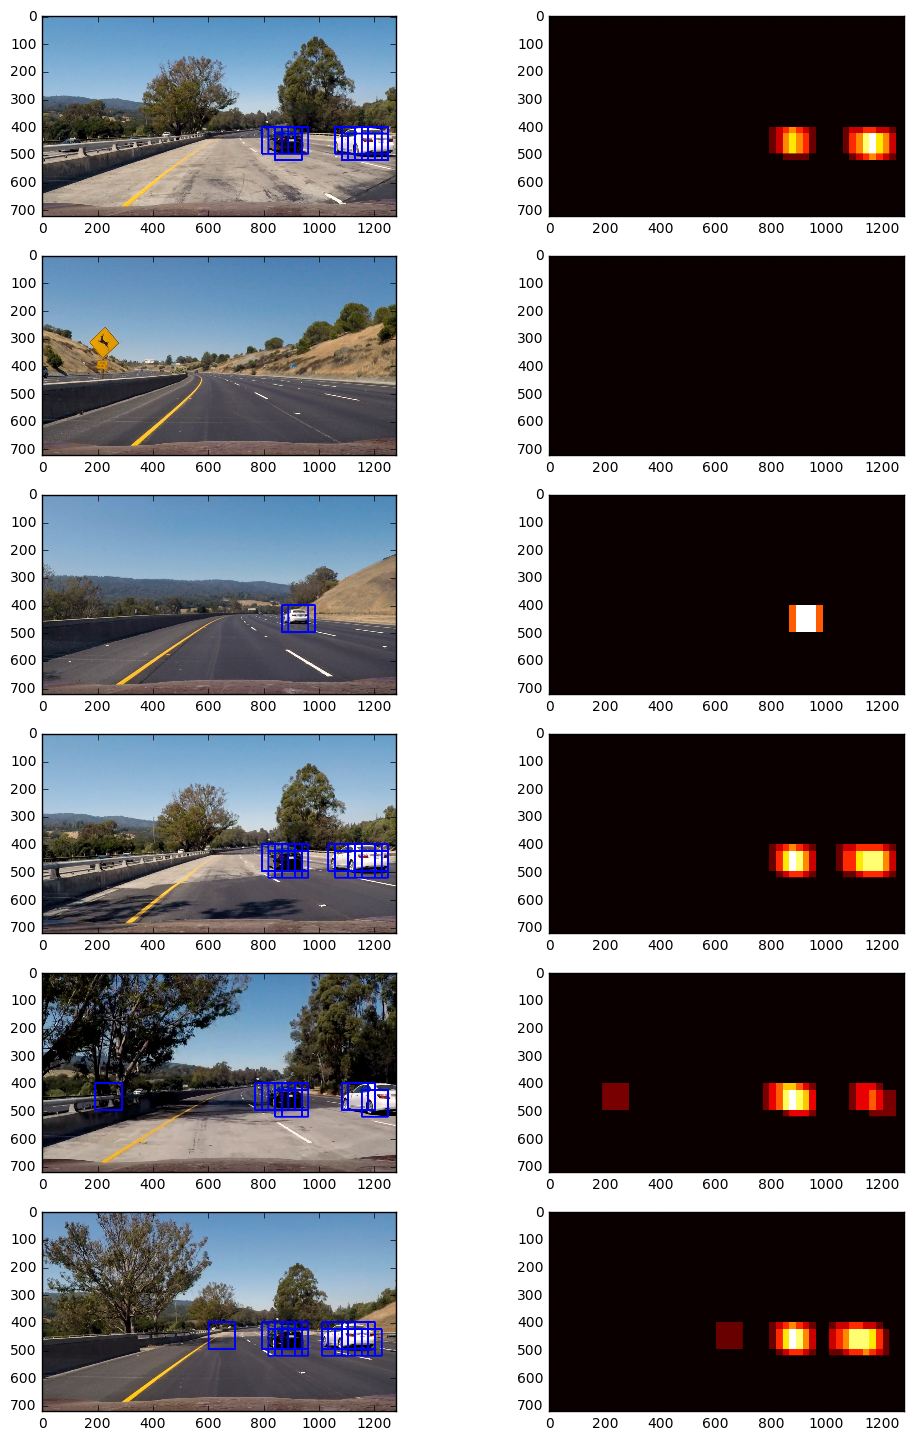

In [194]:
out_images = [] # First I have created empty arrays for output images, heat maps and detected cars (window frames)
out_maps = []
out_titles = []
out_boxes = []

ystart = 400 # As previously explained ystart and ystop values are used to discard areas of the image
             # where cars should not appear.
ystop = 656
scale = 1.5 # After some experimentation this image size scale performed best.

for img_src in example_images: # Looping through example images.
    img_boxes = [] # Empty array for the detected car window frames.
    t = time.time() # Time on start of the window search.
    count=0 # Window count
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    heatmap = np.zeros_like(img[:,:,0]) # Creating initial empty heat map where positive car detections will be marked.
    img = img.astype(np.float32)/255 # Normalising the image to range between 0 and 1.
    
    img_tosearch = img[ystart:ystop,:,:] # Cropping the image only to window search area (Without threes and skyline).
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb') # Color conversion to RGB2YCrCb color channel.
    if scale != 1: # Changing the scale of the image.
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale),np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0] # Extracting individual color channels from the cropped image.
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1 # Defining number of blocks per window based on pixels per cell 
                                                  # (HOG function parameters)
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient*cell_per_block**2 
    window = 64 # Size of window frame that will be used for car classification.
    nblocks_per_window = (window // pix_per_cell) - 1 
    cells_per_step = 2 # Number of cells that the window frame will move per each step 
                       # (another way of defining overlap).
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step # Calculating total number of steps that 
                                                                # the window frame will take.
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Bellow I have calculated HOG features for the complete image at once:
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps): # Looping through HOG features based on the previously calculated parameters.
        for yb in range(nysteps):
            count += 1
            ypos = yb * cells_per_step # Calculating x and y window positions based on current step.
            xpos = xb * cells_per_step
            
            # Bellow HOG features are extracted for the specific window.
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            # Calculating pixel positions for window frame extraction from the YCrCb image:
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # Extracting the image patch based on current window frame:
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            
            # Extracting features from two previously described functions:
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # Scaling the previously calculated features and preforming the prediction (if a car was found in 
            # the window frame or not):
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features,hog_features)).reshape(1, -1))
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1: # If a car was predicted in the window frame with SVM classifier
                                     # following actions will be performed:
                xbox_left = np.int(xleft*scale) # Scaling back x and y coordinates 
                                                # and window frame size to original size.
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                # Drawing the blue rectangle on the original image:
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw, ytop_draw+win_draw+ystart),(0,0,255),6)
                # Appending rectangle coordinates to img_boxes array:
                img_boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                # Adding +1 to heat map on the area where the window frame with predicted car was found:
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1
        
    print(time.time()-t,'seconds to run, total windows = ', count)
        
    out_images.append(draw_img) # Appending calculated values to arrays for plotting.
    out_images.append(heatmap)    
    out_titles.append('')
    out_titles.append('') 
    out_maps.append(heatmap)
    out_boxes.append(img_boxes)

fig = plt.figure(figsize=(12,18))
visualize(fig, 6, 2, out_images, out_titles)


It can be seen above how performance has been improved with the new algorithm. Even though nearly tree times as much windows were calculated (294 in comparison to 100) the new algorithm took less time per sample image.

The function bellow is basically the same as the function above so it will not be explained one more time. The only difference is that this function can opearate on an image input from a video instead on array of sample images.

In [239]:
def find_cars(img, scale):    
    draw_img = np.copy(img)
    heatmap = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:] 
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale),np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient*cell_per_block**2
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features,hog_features)).reshape(1, -1))
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw, ytop_draw+win_draw+ystart),(0,0,255),6)
                img_boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1
    
    return draw_img, heatmap

Function apply_treshold removes car window detections from the heat map that have value of only 1 (false positives in some cases).

Function draw_labeled_bboxes draws blue rectangles on the image to mark positive heat map areas after thresholding.

In [240]:
from scipy.ndimage.measurements import label

def apply_treshold(heatmap, threshold):
    heatmap[heatmap<=threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1]+1): # Iterating through heat map areas containing values of 2 or more.
        nonzero = (labels[0]==car_number).nonzero() # Filtering detected car area for each car (label) separately. 
        # Creating x and y arrays.
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Definition of bounding boxes based on min and max values of the nonzeroy and nonzerox arrays:
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Drawing the boxes on the image:
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return img

Previously described funcitons are shown on the sample images bellow. Now only one rectangle has been drawed per car based on heatmap and all false positives are hidden. 

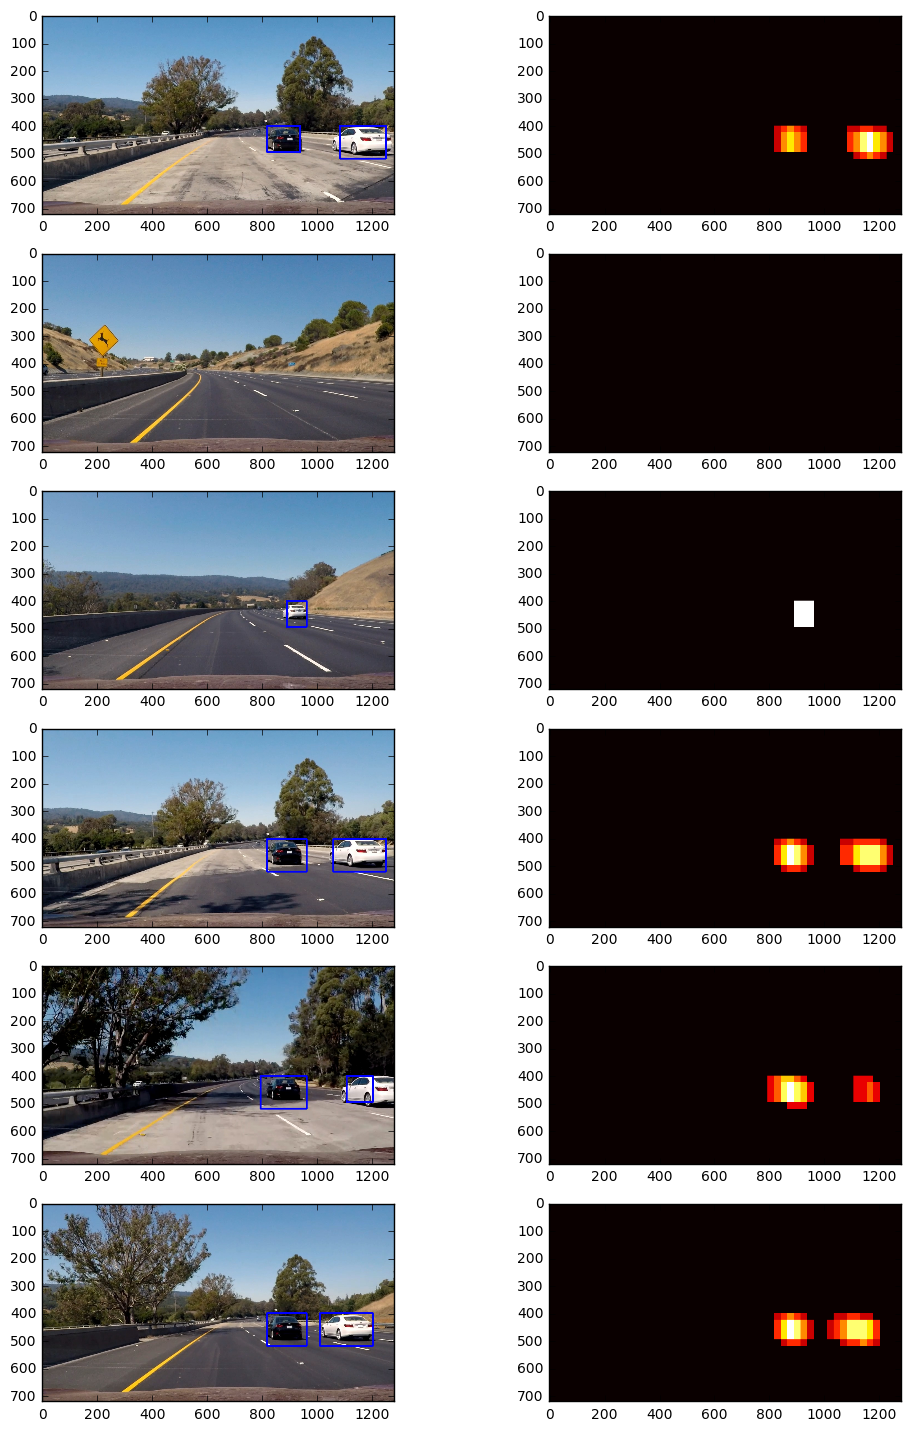

In [274]:
out_images = [] # All parameters have previously been explained.
out_maps = []
ystart = 400
ystop = 656
scale = 1.5
for img_src in example_images: # Iterating over the image samples.
    img = mpimg.imread(img_src)
    out_img, heat_map = find_cars(img, scale) # Finding heat maps with cars.
    apply_treshold(heat_map,1) # Removing false positives.
    labels = label(heat_map) # Extracting car detections separately from the heat map.
    # Saving the results for plotting:
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    out_images.append(draw_img)
    out_images.append(heat_map)
fig = plt.figure(figsize=(12,24))
visualize(fig, 8, 2, out_images, out_titles)
    

To stabilize blue rectangles across the video frames I have averaged heat map arrays over 30 video frames.

Function process_image serves as imput for VideoFileClip funciton. Car detection and rectangle drawing steps are the same as described previously on the sample images. The only tifference is that the steps are performed on video this time.

In [339]:
heat_maps = []

In [340]:
def process_image(img):
    out_img, heat_map = find_cars(img, scale)
    heat_maps.append(heat_map) # Averaging heat map over 30 video frames.
    heat_map_mean = np.mean(np.array(heat_maps), axis=0)
    heat_map_mean = apply_treshold(heat_map_mean,1)
    labels = label(heat_map_mean)
    
    # Drawing blue rectangles on a copy of the image
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    if len(heat_maps)>30: # Removing old heat maps.
        heat_maps.pop(0)
    return draw_img

In [341]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

test_output = 'test.mp4'
#clip = VideoFileClip("test_video.mp4")
clip = VideoFileClip("project_video.mp4")
test_clip = clip.fl_image(process_image)
test_clip.write_videofile(test_output, audio=False)

  self.nchannels))



[MoviePy] >>>> Building video test.mp4
[MoviePy] Writing video test.mp4










  0%|          | 0/1261 [00:00<?, ?it/s]







  0%|          | 1/1261 [00:00<07:06,  2.95it/s]







  0%|          | 2/1261 [00:00<06:52,  3.05it/s]







  0%|          | 3/1261 [00:00<06:43,  3.11it/s]







  0%|          | 4/1261 [00:01<06:36,  3.17it/s]







  0%|          | 5/1261 [00:01<06:37,  3.16it/s]







  0%|          | 6/1261 [00:01<06:39,  3.14it/s]







  1%|          | 7/1261 [00:02<06:43,  3.11it/s]







  1%|          | 8/1261 [00:02<06:45,  3.09it/s]







  1%|          | 9/1261 [00:02<06:45,  3.09it/s]







  1%|          | 10/1261 [00:03<06:47,  3.07it/s]







  1%|          | 11/1261 [00:03<06:41,  3.11it/s]







  1%|          | 12/1261 [00:03<06:45,  3.08it/s]







  1%|          | 13/1261 [00:04<06:45,  3.08it/s]







  1%|          | 14/1261 [00:04<06:45,  3.08it/s]







  1%|          | 15/1261 [00:04<06:52,  3.02it/s]







  1%|▏         | 16/1261 [00:05<06:59,  2.97it/s]







  1%|▏         | 17/1261 [00:05<07:07,  2

[MoviePy] Done.
[MoviePy] >>>> Video ready: test.mp4 



Please find the output video under the following link: https://youtu.be/iGJFBOg742E

## Discussion

The main problem faced is that the algorithm is currently not able to make the distinction between detected cars. For example at one point in video the algorithm has detected 2 cars as one. Improved version of the algorithm would save each vehicle as separate class. By tracking each vehicle in separate class across video frames algorithm would be able to doing better job of not loosing vehicles. Movement prediction of detected vehicles would be possible as well, which is crucial for the real life application.

Another thing that could be improved is using different widow frame sizes. The algorithm currently does a good job in finding cars at closer distances but when the vehicles become smaller due to greather distance they suddenly get lost. 

Real life algorithm should definitely be trained to detect other object and not only cars as well (motorcycles, pedestrians etc.).